# Visualization of coordinates on a sample image

## Imports and declarations

In [6]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision.transforms.functional as F
from torchvision.io import decode_image

from wings.config import COUNTRIES, RAW_DATA_DIR, COORDS_SUFX
from wings.config import IMG_FOLDER_SUFX
from wings.dataset import Dataset


In [7]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]


def preprocess(img: torch.Tensor) -> torch.Tensor:
    img = F.resize(img, [224, 224], interpolation=F.InterpolationMode.BILINEAR, antialias=True)
    # img = F.center_crop(img, self.crop_size)
    if not isinstance(img, torch.Tensor):
        img = F.pil_to_tensor(img)
    img = F.convert_image_dtype(img, torch.float)
    img = F.normalize(img, mean=mean, std=std)
    return img


def denormalize(img: torch.Tensor) -> torch.Tensor:
    mean_d = torch.tensor(mean).view(3, 1, 1)
    std_d = torch.tensor(std).view(3, 1, 1)
    img = img * std_d + mean_d
    img = img.numpy().transpose(1, 2, 0)
    if img.dtype != np.uint8:
        img = (img * 255).astype(np.uint8)
    img = np.ascontiguousarray(img)
    return img

In [8]:
resnet_dataset = Dataset(COUNTRIES, RAW_DATA_DIR, preprocess)

100%|██████████| 21722/21722 [00:00<00:00, 55585.56it/s]


## Visualization raw

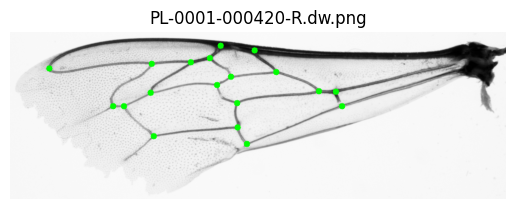

In [9]:
def plt_imshow(img, img_title="image"):
    plt.figure()
    plt.title(img_title)
    plt.imshow(img, cmap='gray', vmin=0, vmax=255)
    plt.axis("off")
    plt.show()


def plot_coords(img, coords, spot_size=12, save_path=None):
    x_size, y_size = img.shape[2], img.shape[1]

    img = img.repeat(3, 1, 1)
    img = img.numpy().transpose(1, 2, 0)  # Convert to HWC format
    plt.imshow(img)

    x_coords, y_coords = coords
    y_coords = y_size - y_coords

    plt.scatter(x_coords, y_coords, s=spot_size, c='lime', alpha=0.8)  # Plot circles

    plt.axis("off")
    plt.show()


def read_original(filename, data_folder=RAW_DATA_DIR):
    country = filename.split('-', 1)[0]
    img = decode_image(data_folder / f"{country}{IMG_FOLDER_SUFX}" / filename)

    df = pd.read_csv(data_folder / f"{country}{COORDS_SUFX}")
    row = df[df['file'] == filename].iloc[0]

    targets = row.iloc[1:]
    x_coords, y_coords = targets.iloc[::2], targets.iloc[1::2]
    coords = x_coords, y_coords

    plot_coords(img, coords)
    return coords


def read_original_cv2(filename, data_folder=RAW_DATA_DIR):
    country = filename.split('-', 1)[0]
    imgpath = data_folder / f"{country}{IMG_FOLDER_SUFX}" / filename
    img = cv2.imread(imgpath, cv2.IMREAD_COLOR)

    df = pd.read_csv(data_folder / f"{country}{COORDS_SUFX}")
    row = df[df['file'] == filename].iloc[0]

    targets = row.iloc[1:]
    x_coords, y_coords = targets.iloc[::2], targets.iloc[1::2]
    coords = x_coords, y_coords

    coords_cv2(img, coords, filename=filename)


def read_original_cv3(filename, data_folder=RAW_DATA_DIR):
    country = filename.split('-', 1)[0]
    imgpath = data_folder / f"{country}{IMG_FOLDER_SUFX}" / filename
    img = cv2.imread(imgpath, cv2.IMREAD_COLOR)

    df = pd.read_csv(data_folder / f"{country}{COORDS_SUFX}")
    row = df[df['file'] == filename].iloc[0]

    targets = pd.to_numeric(row.iloc[1:].values)
    targets = torch.tensor(targets, dtype=torch.float32)

    coords_cv3(img, targets, filename=filename)


def coords_cv2(img, coords, *, filename='image', spot_size=6, save_path=None):
    x_size, y_size = img.shape[1], img.shape[0]
    x_coords, y_coords = coords
    y_coords = y_size - y_coords

    for x, y in zip(x_coords, y_coords):
        cv2.circle(img, (x, y), spot_size, (0, 255, 0), -1)

    plt_imshow(img, filename)


def coords_cv3(img, targets, *, filename=None, spot_size=6, save_path=None):
    x_size, y_size = img.shape[1], img.shape[0]
    x_coords, y_coords = targets[::2], targets[1::2]
    y_coords = y_size - y_coords

    for x, y in zip(x_coords, y_coords):
        x, y = int(x), int(y)
        cv2.circle(img, (x, y), spot_size, (0, 255, 0), -1)

    plt_imshow(img, filename)


read_original_cv3(filename="PL-0001-000420-R.dw.png")

file                           AT-0001-031-003678-L.dw.png
label    [tensor(219.), tensor(191.), tensor(238.), ten...
Name: 0, dtype: object
torch.Size([3, 224, 224])
tensor([219., 191., 238., 190., 292., 270., 287., 216., 294., 131., 359., 276.,
        409., 307., 387., 284., 431., 251., 401., 228., 450., 197., 456., 153.,
        471., 121., 487., 299., 525., 263., 604., 224., 642., 222., 651., 193.,
         91., 259.])
(224, 224, 3)
<class 'numpy.ndarray'>
uint8


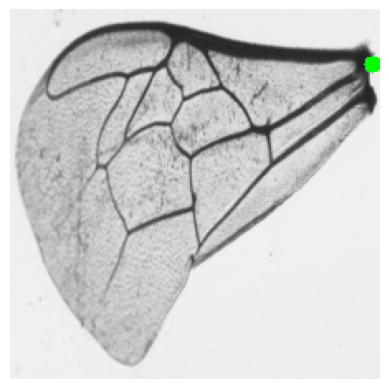

In [10]:
image, label = resnet_dataset[0]
print(resnet_dataset.coords_df.iloc[0])
print(image.shape)
print(label)
image = denormalize(image)
print(image.shape)
print(type(image))
print(image.dtype)

coords_cv3(image, label, spot_size=5)